In [2]:
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)
download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()


[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:14:25.348.840 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:14:25.349.837 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:14:25.350.835 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:14:25.352.828 [mindspore\dataset\core\validator_helpers.py:744] 'HWC

In [4]:
import mindspore.nn as nn

class LeNet5(nn.Cell):
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为num_channel,输出的通道数为6,卷积核大小为5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为6，输出的通道数为16,卷积核大小为5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # 全连接层，输入个数为16*5*5，输出个数为120
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        # 全连接层，输入个数为120，输出个数为84
        self.fc2 = nn.Dense(120, 84)
        # 全连接层，输入个数为84，分类的个数为num_class
        self.fc3 = nn.Dense(84, num_class)
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 多维数组展平为一维数组
        self.flatten = nn.Flatten()

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [6]:
import mindspore.nn as nn

# 应用LeNet-5
network = LeNet5()

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)


In [7]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数，模型训练保存参数的step为1875
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=50)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)


In [48]:
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型，并保存为lenet-1_1875.ckpt文件
model.train(50, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])


Epoch:[  0/ 50], step:[ 1875/ 1875], loss:[0.027/0.425], time:19.948 ms, lr:0.01000
Epoch time: 25574.004 ms, per step time: 13.639 ms, avg loss: 0.425
Epoch:[  1/ 50], step:[ 1875/ 1875], loss:[0.087/0.063], time:20.944 ms, lr:0.01000
Epoch time: 25301.199 ms, per step time: 13.494 ms, avg loss: 0.063
Epoch:[  2/ 50], step:[ 1875/ 1875], loss:[0.006/0.043], time:18.949 ms, lr:0.01000
Epoch time: 24885.799 ms, per step time: 13.272 ms, avg loss: 0.043
Epoch:[  3/ 50], step:[ 1875/ 1875], loss:[0.010/0.034], time:19.946 ms, lr:0.01000
Epoch time: 24677.880 ms, per step time: 13.162 ms, avg loss: 0.034
Epoch:[  4/ 50], step:[ 1875/ 1875], loss:[0.000/0.028], time:18.949 ms, lr:0.01000
Epoch time: 24642.309 ms, per step time: 13.143 ms, avg loss: 0.028
Epoch:[  5/ 50], step:[ 1875/ 1875], loss:[0.001/0.024], time:18.950 ms, lr:0.01000
Epoch time: 24859.634 ms, per step time: 13.258 ms, avg loss: 0.024
Epoch:[  6/ 50], step:[ 1875/ 1875], loss:[0.024/0.021], time:19.946 ms, lr:0.01000
Epoc

In [10]:
from mindspore import load_checkpoint, load_param_into_net
from mindvision.classification.dataset import Mnist
from mindspore.train import Model

# 将模型参数存入parameter的字典中，这里加载的是上面训练过程中保存的模型参数
param_dict = load_checkpoint("./lenet/lenet-15_1875.ckpt")

# 重新定义一个LeNet神经网络
net = LeNet5(10, 1)

# 将参数加载到网络中
load_param_into_net(net, param_dict)

# 重新定义优化器函数
net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.01, momentum=0.9)
model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"accuracy"})

# 调用eval()进行推理
download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)
dataset_eval = download_eval.run()
acc = model.eval(dataset_eval)

print("{}".format(acc))


[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:17:06.771.992 [mindspore\train\serialization.py:1469] For 'load_param_into_net', remove parameter prefix name: backbone., continue to load.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:17:07.410.285 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:17:07.411.282 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:17:07.411.282 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in

{'accuracy': 0.9895833333333334}


[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:18:42.265.857 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:18:42.266.812 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:18:42.267.808 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24416:39192,MainProcess):2024-05-01-01:18:42.268.805 [mindspore\dataset\core\validator_helpers.py:744] 'HWC

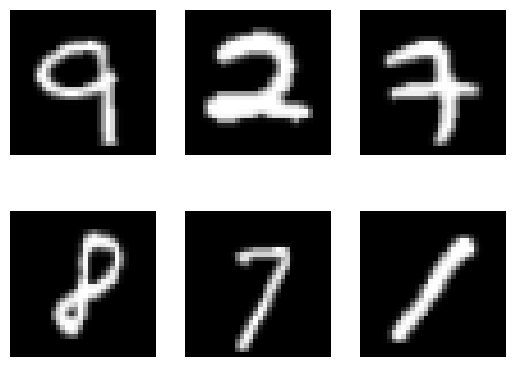

Predicted: "[9 2 7 8 7 1]", Actual: "[9 2 7 8 7 1]"


In [11]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("./mnist", split="train", batch_size=6, resize=32)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
    plt.axis('off')
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')
